In [1]:
!pip install graphviz


^C


In [88]:
from dataclasses import dataclass
from collections import defaultdict
from typing import List, Set, Optional, DefaultDict
import os.path
import logging
import graphviz

logger = logging.getLogger("uk_wordnet")


@dataclass
class LexicalUnit:
    name: str

    def __str__(self):
        return self.name

    def __hash__(self):
        return hash(self.name)


@dataclass
class RelationType:
    name: str

    def __str__(self):
        return self.name

    def __hash__(self):
        return hash((self.name,))

    def __eq__(self, othr):
        if isinstance(othr, type(self)):
            return self.name == othr.name

        if isinstance(othr, str):
            return self.name == othr

        return False


@dataclass
class Synset:
    lexical_units: List[LexicalUnit]
    definition: str
    variant: int
    relations: DefaultDict[RelationType, List]

    def __str__(self):
        return f"{self.lexical_units[0].name}.{self.variant}"

    def __hash__(self):
        return hash((self.lexical_units[0].name, self.variant))


class Wordnet:
    synset_lookup = defaultdict(list)
    relation_lookup = {}

    def deref_synset(self, synset):
        synsets_found = len(self.synset_lookup[synset])
        if synsets_found > 1:
            logger.warning(
                f"'{synset}' lexical unit has more than 1 synset, it has {synsets_found}!"
            )
            return None
        elif synsets_found == 0:
            logger.warning(f"'{synset}' lexical unit has no synsets at all!")
            return None

        return self.synset_lookup[synset][0]

    def __init__(self, concepts_file, relation_files):

        with open(concepts_file) as fp:
            for l in fp:
                lemmas, gloss = l.strip().split(": ")
                
                synset = None
                for lemma in lemmas.split(","):
                    lemma = lemma.strip()
                    lu = LexicalUnit(name=lemma)

                    variant = len(synset_lookup[lemma])
                    if synset is None:
                        synset = Synset(
                            lexical_units=[lu],
                            definition=gloss,
                            variant=variant,
                            relations=defaultdict(list),
                        )
                    else:
                        synset.lexical_units.append(lu)

                    self.synset_lookup[lemma].append(synset)

        for rel_file in relation_files:
            rel_name, _ = os.path.splitext(os.path.basename(rel_file))
            rel = RelationType(name=rel_name)
            self.relation_lookup[rel_name] = rel

            with open(rel_file, "r") as fp:
                for l in fp:
                    l = l.strip()
                    if not l:
                        continue

                    try:
                        subj, obj = l.split(" -> ")
                    except ValueError:
                        logger.warning(
                            f"Cannot parse relation '{l}' of type '{rel_name}'"
                        )
                        continue

                    subj_deref = self.deref_synset(subj.strip())
                    obj_deref = self.deref_synset(obj.strip())

                    if subj_deref is None or obj_deref is None:
                        logger.warning(
                            f"Skipping relation of type '{rel_name}' between '{subj}' and '{obj}'"
                        )
                        continue

                    subj_deref.relations[rel].append(obj_deref)

    def export_to_graphviz(self, only_relations=None, ignore_orphans=False):
        if only_relations is None:
            only_relations = list(self.relation_lookup.values())
            

        g = graphviz.Graph("G", filename="process.gv")

        for synset_group in self.synset_lookup.values():
            for synset in synset_group:
                if any(synset.relations.values()) or not ignore_orphans:
                    g.node(str(synset))

                    for rel in synset.relations:
                        if rel not in only_relations:
                            continue

                        for obj in synset.relations[rel]:
                            g.node(str(obj))
                            g.edge(str(synset), str(obj), label=str(rel))

        return g


import glob

wn = Wordnet(
    concepts_file="../resources/wn-ua-2009/basic-concepts.txt",
    relation_files=[
        f
        for f in glob.glob("../resources/wn-ua-2009/*.txt")
        
        if os.path.basename(f) not in ["readme.txt", "basic-concepts.txt"]
    ],
)


'вік, тисячоліття' lexical unit has no synsets at all!
'століття' lexical unit has no synsets at all!
Skipping relation of type 'part-meronym' between 'вік, тисячоліття' and 'століття'
'століття' lexical unit has no synsets at all!
'десятиліття' lexical unit has no synsets at all!
Skipping relation of type 'part-meronym' between 'століття' and 'десятиліття'
'десятиліття' lexical unit has no synsets at all!
'рік' lexical unit has more than 1 synset, it has 2!
Skipping relation of type 'part-meronym' between 'десятиліття' and 'рік'
'рік' lexical unit has more than 1 synset, it has 2!
'пора року' lexical unit has no synsets at all!
Skipping relation of type 'part-meronym' between 'рік' and 'пора року'
'пора року' lexical unit has no synsets at all!
'місяць' lexical unit has more than 1 synset, it has 3!
Skipping relation of type 'part-meronym' between 'пора року' and 'місяць'
'ранок' lexical unit has no synsets at all!
'світанок' lexical unit has no synsets at all!
Skipping relation of ty

'організм' lexical unit has no synsets at all!
'представник ядерних' lexical unit has no synsets at all!
Skipping relation of type 'hyponym' between 'організм' and 'представник ядерних'
'представник ядерних' lexical unit has no synsets at all!
'тварина' lexical unit has no synsets at all!
Skipping relation of type 'hyponym' between 'представник ядерних' and 'тварина'
'тварина' lexical unit has no synsets at all!
'представник хордових' lexical unit has no synsets at all!
Skipping relation of type 'hyponym' between 'тварина' and 'представник хордових'
'представник хордових' lexical unit has no synsets at all!
'представник хребетних' lexical unit has no synsets at all!
Skipping relation of type 'hyponym' between 'представник хордових' and 'представник хребетних'
'представник хребетних' lexical unit has no synsets at all!
'ссавець' lexical unit has no synsets at all!
Skipping relation of type 'hyponym' between 'представник хребетних' and 'ссавець'
'ссавець' lexical unit has no synsets at a

'проміжок часу' lexical unit has no synsets at all!
'вік, тисячоліття' lexical unit has no synsets at all!
Skipping relation of type 'hyponym' between 'проміжок часу' and 'вік, тисячоліття'
'проміжок часу' lexical unit has no synsets at all!
'епоха, вік' lexical unit has no synsets at all!
Skipping relation of type 'hyponym' between 'проміжок часу' and 'епоха, вік'
'проміжок часу' lexical unit has no synsets at all!
'пора, година' lexical unit has no synsets at all!
Skipping relation of type 'hyponym' between 'проміжок часу' and 'пора, година'
'проміжок часу' lexical unit has no synsets at all!
'хвиля, мить' lexical unit has no synsets at all!
Skipping relation of type 'hyponym' between 'проміжок часу' and 'хвиля, мить'
'проміжок часу' lexical unit has no synsets at all!
'відпочинковий час' lexical unit has no synsets at all!
Skipping relation of type 'hyponym' between 'проміжок часу' and 'відпочинковий час'
'пора дня' lexical unit has no synsets at all!
'світанок' lexical unit has no 

	 характеристика.1
	 психологічна властивість.1
	 абстрактне поняття.1


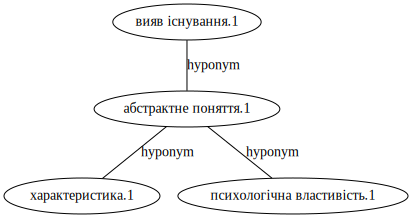

In [89]:
wn.export_to_graphviz(only_relations=["hyponym"], ignore_orphans=True)



In [91]:
print(wn.synset_lookup["стан"])



[Synset(lexical_units=[LexicalUnit(name='стан')], definition='Обставини, умови, в яких хто-, що-небудь перебуває, існує; ситуація, зумовлена певними обставинами, умовами', variant=2, relations=defaultdict(<class 'list'>, {})), Synset(lexical_units=[LexicalUnit(name='стан')], definition='Сукупність ознак, рис, що характеризують предмет, явище в даний момент', variant=2, relations=defaultdict(<class 'list'>, {}))]


In [39]:
l


defaultdict(list, {})